Starting improved KNN model training...
Data shape: (308854, 18)
Target variable distribution: Counter({0: 283752, 1: 24971})
Heart disease proportion: 0.081

Training set distribution: Counter({0: 227001, 1: 19977})
Test set distribution: Counter({0: 56751, 1: 4994})

Applying SMOTE for class imbalance handling...
Training set distribution after SMOTE: Counter({0: 227001, 1: 227001})

Testing different K values for recall optimization...
K=3: Recall=0.4986, Accuracy=0.7616
K=5: Recall=0.5623, Accuracy=0.7432
K=7: Recall=0.6027, Accuracy=0.7324
K=9: Recall=0.6306, Accuracy=0.7255
K=11: Recall=0.6536, Accuracy=0.7196
K=15: Recall=0.6832, Accuracy=0.7100
K=20: Recall=0.7080, Accuracy=0.7058

Best K value: 20
Best recall: 0.7080

=== Final Model Performance (K=20, Threshold=0.50) ===
Recall: 0.7080
Precision: 0.1747
Accuracy: 0.7058
AUC: 0.7678

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56751
           1 

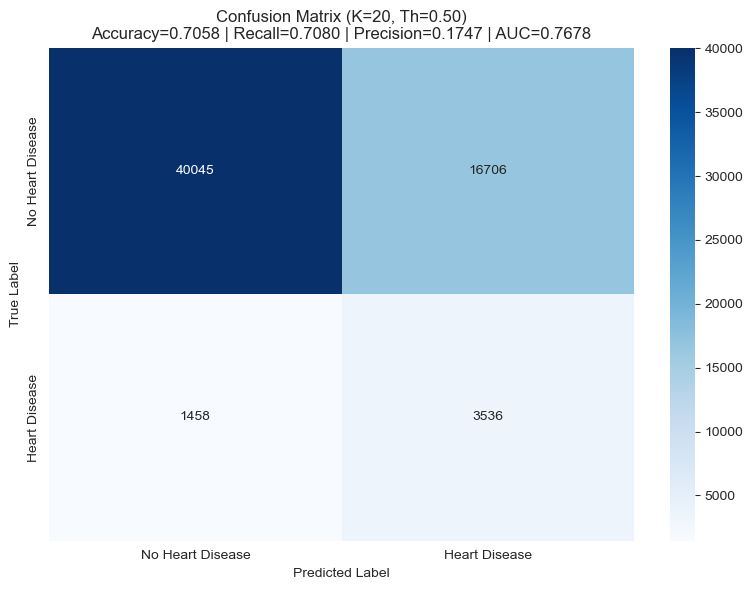

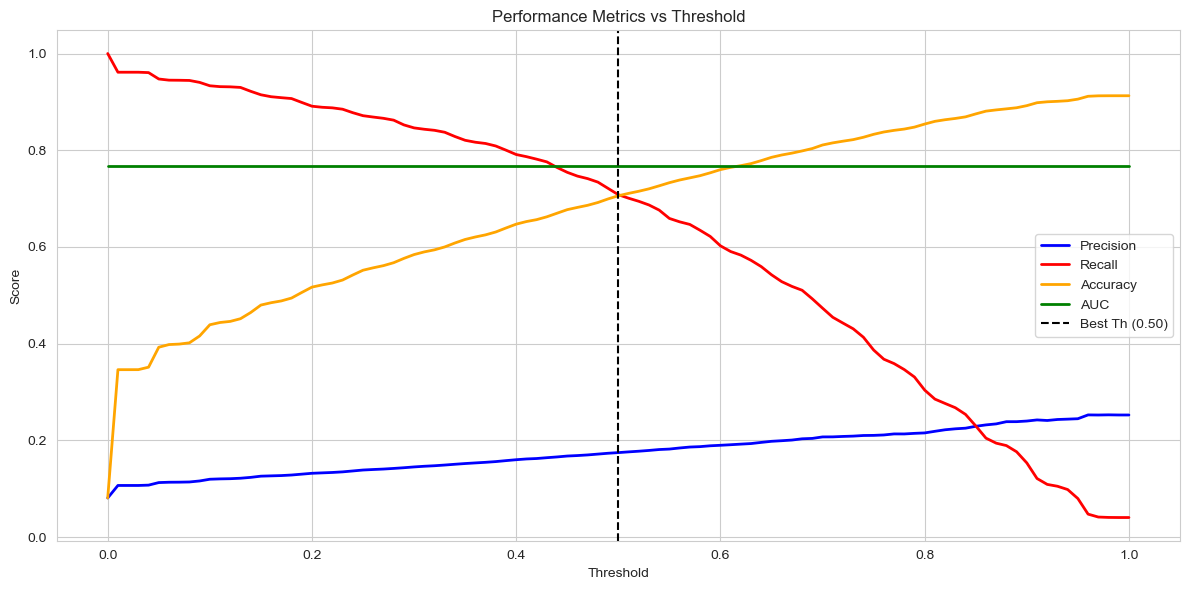

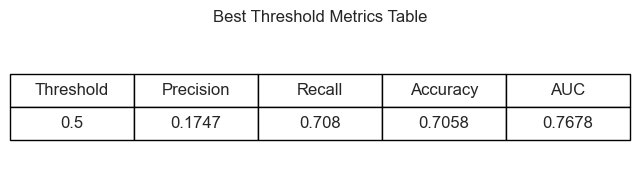


Model saved: improved_knn_model.pkl


In [8]:
# Basic KNN + SMOTE + Probability Threshold Optimization
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    recall_score, accuracy_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# ===========================
# Settings
# ===========================
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set_style("whitegrid")

print("Starting improved KNN model training...")

# ===========================
# Load data
# ===========================
data = pd.read_csv('CVD_cleaned.csv').drop('Checkup', axis=1)
print(f"Data shape: {data.shape}")

# ===========================
# Preprocessing function
# ===========================
def preprocess_data(df):
    df_processed = df.copy()
    df_processed = df_processed.drop_duplicates()

    # Binary variables
    binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
                   'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
    for col in binary_cols:
        df_processed[col] = df_processed[col].apply(
            lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x)
        ).astype(int)

    # Categorical variables
    categorical_cols = ['General_Health', 'Age_Category', 'Sex']
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))

    # Numerical variables
    numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    scaler = StandardScaler()
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

    return df_processed, scaler

# ===========================
# Apply preprocessing
# ===========================
data_processed, scaler = preprocess_data(data)
X = data_processed.drop('Heart_Disease', axis=1)
y = data_processed['Heart_Disease']

print(f"Target variable distribution: {Counter(y)}")
print(f"Heart disease proportion: {y.mean():.3f}")

# ===========================
# Train-test split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set distribution: {Counter(y_train)}")
print(f"Test set distribution: {Counter(y_test)}")

# ===========================
# SMOTE
# ===========================
print("\nApplying SMOTE for class imbalance handling...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Training set distribution after SMOTE: {Counter(y_train_smote)}")

# ===========================
# Find best K (optimize recall)
# ===========================
print("\nTesting different K values for recall optimization...")

best_recall = 0
best_k = 3
best_model = None

for k in [3, 5, 7, 9, 11, 15, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_smote, y_train_smote)
    y_pred = knn.predict(X_test)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"K={k}: Recall={recall:.4f}, Accuracy={accuracy:.4f}")

    if recall > best_recall:
        best_recall = recall
        best_k = k
        best_model = knn

print(f"\nBest K value: {best_k}")
print(f"Best recall: {best_recall:.4f}")

# ===========================
# Threshold optimization
# ===========================
y_proba = best_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.01, 0.01)
precision_list = []
recall_list = []
accuracy_list = []
auc_list = []

best_threshold = 0.5
best_precision = 0

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_proba)

    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    auc_list.append(auc)

    # Pick threshold based on precision priority (can modify logic)
    if recall >= best_recall and precision > best_precision:
        best_precision = precision
        best_threshold = t

# ===========================
# Final model evaluation
# ===========================
y_pred_final = (y_proba >= best_threshold).astype(int)
final_recall = recall_score(y_test, y_pred_final)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_proba)

print(f"\n=== Final Model Performance (K={best_k}, Threshold={best_threshold:.2f}) ===")
print(f"Recall: {final_recall:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"AUC: {final_auc:.4f}")

# ===========================
# Classification Report
# ===========================
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# ===========================
# Confusion Matrix + Metrics Table
# ===========================
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title(f'Confusion Matrix (K={best_k}, Th={best_threshold:.2f})\n'
          f'Accuracy={final_accuracy:.4f} | Recall={final_recall:.4f} | '
          f'Precision={final_precision:.4f} | AUC={final_auc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics Table
cell_text = [[
    f"{final_auc:.4f}",
    f"{final_accuracy:.4f}",
    f"{final_recall:.4f}",
    f"{final_precision:.4f}"
]]
columns = ["AUROC", "Accuracy", "Recall", "Precision"]

table = plt.table(
    cellText=cell_text,
    colLabels=columns,
    loc='upper right',
    cellLoc='center',
    colLoc='center',
    bbox=[0.5, 0.75, 0.45, 0.15]
)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.tight_layout()
plt.show()

# ===========================
# Threshold Curve Plot
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_list, label='Precision', color='blue', linewidth=2)
plt.plot(thresholds, recall_list, label='Recall', color='red', linewidth=2)
plt.plot(thresholds, accuracy_list, label='Accuracy', color='orange', linewidth=2)
plt.plot(thresholds, auc_list, label='AUC', color='green', linewidth=2)
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Th ({best_threshold:.2f})')
plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================
# Metrics Table (Best Threshold)
# ===========================
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

best_row = metrics_df.loc[np.isclose(metrics_df['Threshold'], best_threshold, atol=1e-5)]
plt.figure(figsize=(8, 2))
plt.axis('off')
table = plt.table(cellText=best_row.round(4).values,
                  colLabels=best_row.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
plt.title('Best Threshold Metrics Table')
plt.show()

# ===========================
# Save model and scaler
# ===========================
joblib.dump(best_model, 'improved_knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(f"\nModel saved: improved_knn_model.pkl")


Starting improved KNN model training with threshold optimization...
Data shape: (308854, 18)
Target distribution: Counter({0: 283752, 1: 24971})
Heart disease proportion: 0.081

Train set: Counter({0: 227001, 1: 19977})
Test set: Counter({0: 56751, 1: 4994})

Applying SMOTE for class imbalance...
Train set after SMOTE: Counter({0: 227001, 1: 227001})

Testing different K values for best recall...
K=3: Recall=0.4986, Accuracy=0.7616
K=5: Recall=0.5623, Accuracy=0.7432
K=7: Recall=0.6027, Accuracy=0.7324
K=9: Recall=0.6306, Accuracy=0.7255
K=11: Recall=0.6536, Accuracy=0.7196
K=15: Recall=0.6832, Accuracy=0.7100
K=20: Recall=0.7080, Accuracy=0.7058

Best K value: 20, Best Recall: 0.7080

Optimal threshold: 0.54, Precision=0.1811

=== Final Model Performance (K=20, Threshold=0.54) ===
Precision: 0.1811
Recall: 0.6762
Accuracy: 0.7264
AUC: 0.7678

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56751
           1

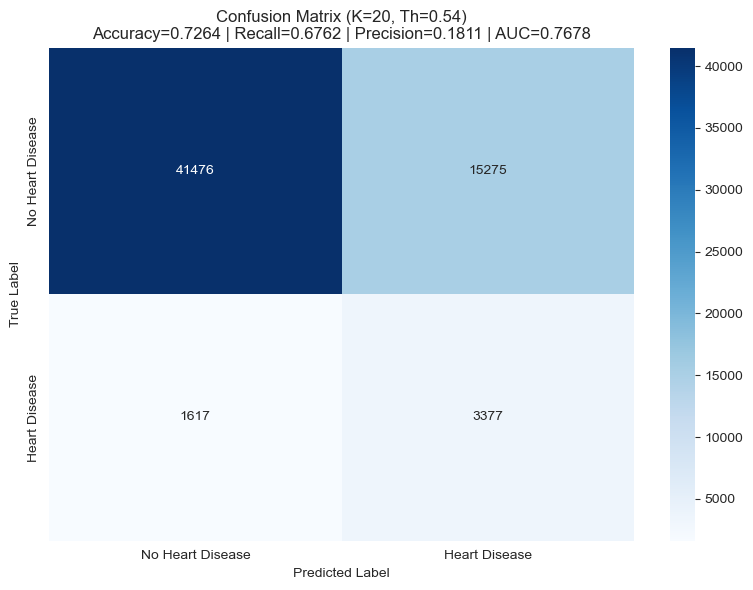

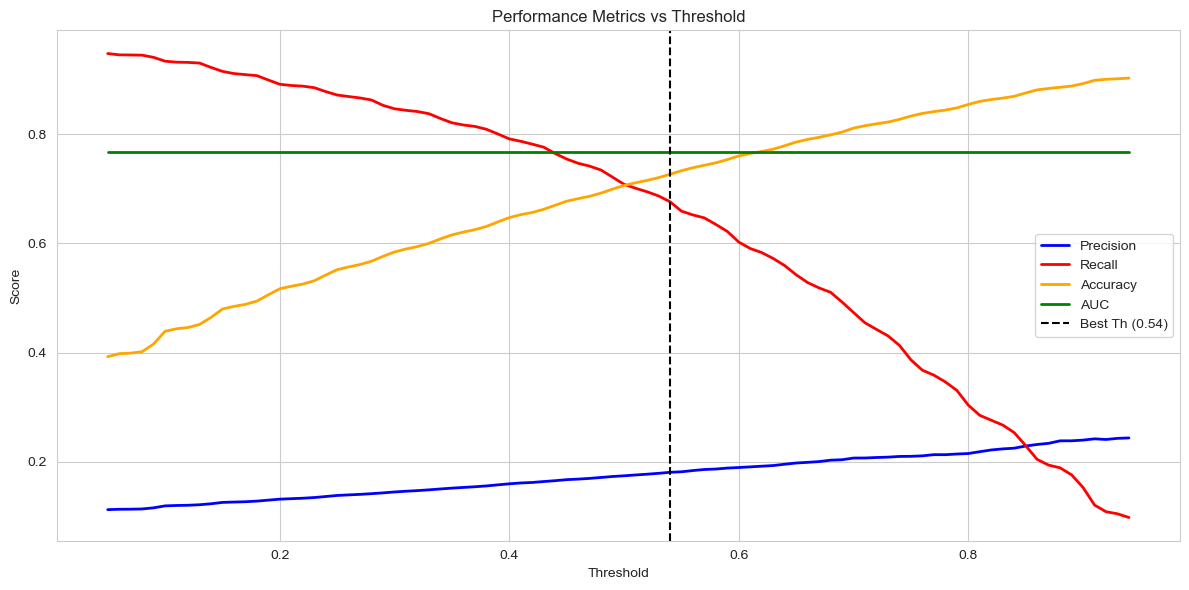

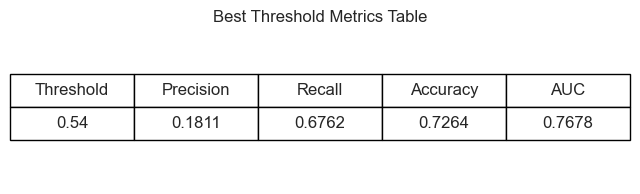


 Model and scaler saved successfully.


In [9]:
#KNN + SMOTE + Threshold Tuning
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# =============================
# Basic settings
# =============================
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set_style("whitegrid")
print("Starting improved KNN model training with threshold optimization...")

# =============================
# Load dataset
# =============================
data = pd.read_csv('CVD_cleaned.csv').drop('Checkup', axis=1)
print(f"Data shape: {data.shape}")

# =============================
# Data preprocessing
# =============================
def preprocess_data(df):
    df_processed = df.copy()
    df_processed = df_processed.drop_duplicates()

    # Binary variables
    binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
                   'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
    for col in binary_cols:
        df_processed[col] = df_processed[col].apply(
            lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x)
        ).astype(int)

    # Label encoding for categorical variables
    categorical_cols = ['General_Health', 'Age_Category', 'Sex']
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))

    # Standardize numeric variables
    numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    scaler = StandardScaler()
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

    return df_processed, scaler

# Apply preprocessing
data_processed, scaler = preprocess_data(data)
X = data_processed.drop('Heart_Disease', axis=1)
y = data_processed['Heart_Disease']

print(f"Target distribution: {Counter(y)}")
print(f"Heart disease proportion: {y.mean():.3f}")

# =============================
# Train-test split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {Counter(y_train)}")
print(f"Test set: {Counter(y_test)}")

# =============================
# Apply SMOTE for class balancing
# =============================
print("\nApplying SMOTE for class imbalance...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Train set after SMOTE: {Counter(y_train_smote)}")

# =============================
# Find best K based on Recall
# =============================
print("\nTesting different K values for best recall...")

best_recall = 0
best_k = 3
best_model = None

for k in [3, 5, 7, 9, 11, 15, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_smote, y_train_smote)
    y_pred = knn.predict(X_test)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"K={k}: Recall={recall:.4f}, Accuracy={accuracy:.4f}")
    if recall > best_recall:
        best_recall = recall
        best_k = k
        best_model = knn

print(f"\nBest K value: {best_k}, Best Recall: {best_recall:.4f}")

# =============================
# Threshold Optimization
# =============================
y_proba = best_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.05, 0.95, 0.01)
best_precision = 0
best_threshold = 0.5
target_recall = best_recall * 0.95  # maintain at least 95% of best recall

precision_list = []
recall_list = []
accuracy_list = []
auc_list = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_proba)

    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    auc_list.append(auc)

    if recall >= target_recall and precision > best_precision:
        best_precision = precision
        best_threshold = t

print(f"\nOptimal threshold: {best_threshold:.2f}, Precision={best_precision:.4f}")

# =============================
# Final Evaluation
# =============================
y_pred_final = (y_proba >= best_threshold).astype(int)
final_recall = recall_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_proba)

print(f"\n=== Final Model Performance (K={best_k}, Threshold={best_threshold:.2f}) ===")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"AUC: {final_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# =============================
# Confusion Matrix
# =============================
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title(f'Confusion Matrix (K={best_k}, Th={best_threshold:.2f})\n'
          f'Accuracy={final_accuracy:.4f} | Recall={final_recall:.4f} | '
          f'Precision={final_precision:.4f} | AUC={final_auc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# =============================
# Threshold Curve: Precision, Recall, Accuracy
# =============================
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_list, label='Precision', color='blue', linewidth=2)
plt.plot(thresholds, recall_list, label='Recall', color='red', linewidth=2)
plt.plot(thresholds, accuracy_list, label='Accuracy', color='orange', linewidth=2)
plt.plot(thresholds, auc_list, label='AUC', color='green', linewidth=2)
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Th ({best_threshold:.2f})')

plt.title('Performance Metrics vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================
# Metrics Table Plot
# =============================
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

# Highlight the best threshold row
best_row = metrics_df.loc[np.isclose(metrics_df['Threshold'], best_threshold, atol=1e-5)]

plt.figure(figsize=(8, 2))
plt.axis('off')
table = plt.table(cellText=best_row.round(4).values,
                  colLabels=best_row.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
plt.title('Best Threshold Metrics Table')
plt.show()

# =============================
# Save model
# =============================
joblib.dump(best_model, 'improved_knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n Model and scaler saved successfully.")


Data shape: (308854, 18)

Best K=20, Best Recall=0.7143

Optimal Threshold: 0.23, Precision: 0.1891, Recall: 0.6832

=== Final Model Performance ===
Precision: 0.1891
Recall: 0.6832
Accuracy: 0.7376
AUC: 0.7821
              precision    recall  f1-score   support

           0     0.9638    0.7424    0.8387     56777
           1     0.1891    0.6832    0.2963      4994

    accuracy                         0.7376     61771
   macro avg     0.5765    0.7128    0.5675     61771
weighted avg     0.9012    0.7376    0.7949     61771



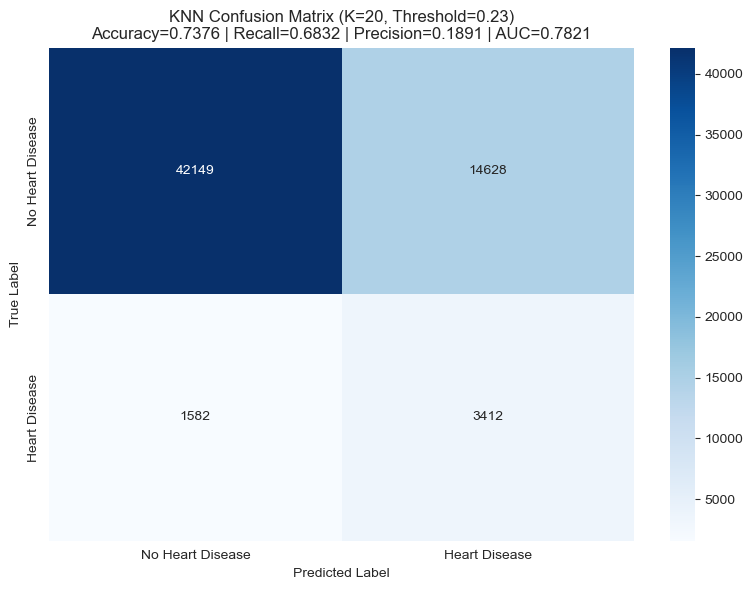

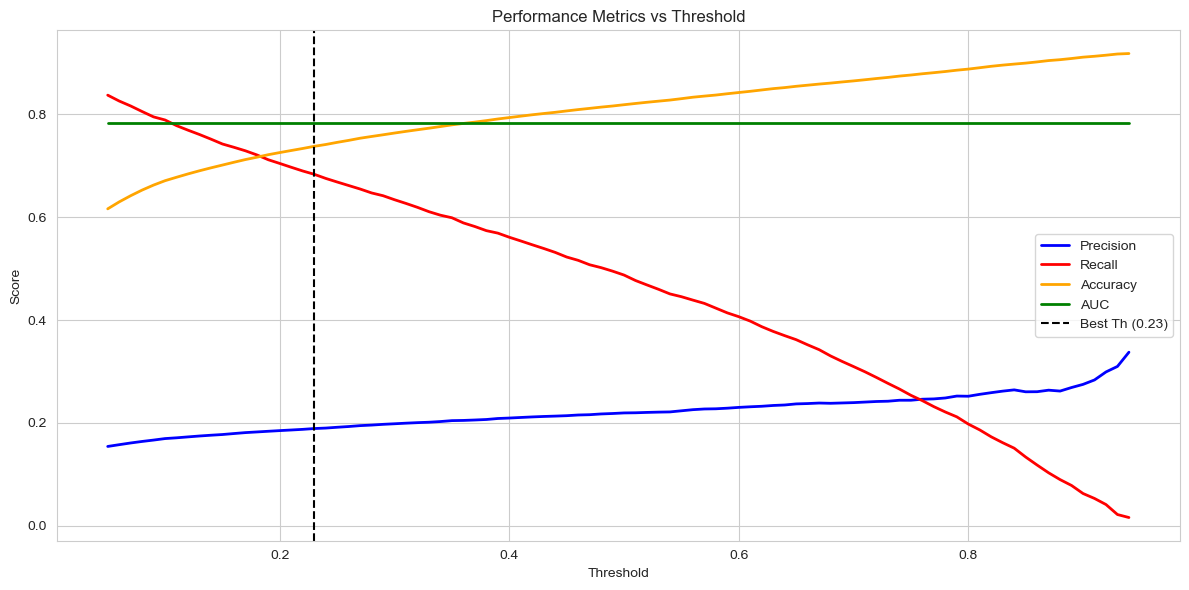

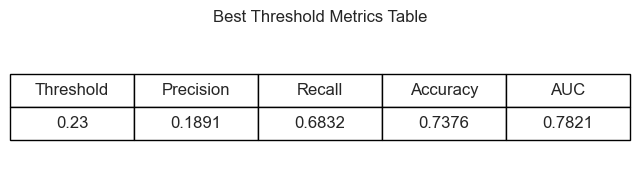


✅ Calibrated KNN model and scaler saved successfully.


In [10]:
#KNN + SMOTE + Probability Calibration + Threshold Tuning
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# ===========================
# Basic settings
# ===========================
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set_style("whitegrid")

# ===========================
# Load and preprocess data
# ===========================
data = pd.read_csv('CVD_cleaned.csv').drop('Checkup', axis=1)
print(f"Data shape: {data.shape}")

def preprocess_data(df):
    df_processed = df.copy()
    # Binary encoding
    binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
                   'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
    for col in binary_cols:
        df_processed[col] = df_processed[col].apply(lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x)).astype(int)

    # Categorical encoding
    categorical_cols = ['General_Health', 'Age_Category', 'Sex']
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))

    # Standardize numeric features
    numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    scaler = StandardScaler()
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])
    return df_processed, scaler

data_processed, scaler = preprocess_data(data)
X = data_processed.drop('Heart_Disease', axis=1)
y = data_processed['Heart_Disease']

# ===========================
# Train-test split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===========================
# Apply SMOTE
# ===========================
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ===========================
# KNN model training
# ===========================
best_recall = 0
best_k = 3
best_model = None
for k in [3, 5, 7, 9, 11, 15, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_smote, y_train_smote)
    y_pred = knn.predict(X_test)
    recall = recall_score(y_test, y_pred)
    if recall > best_recall:
        best_recall = recall
        best_k = k
        best_model = knn

print(f"\nBest K={best_k}, Best Recall={best_recall:.4f}")

# ===========================
# Probability calibration
# ===========================
calibrated_knn = CalibratedClassifierCV(best_model, cv=3)
calibrated_knn.fit(X_train_smote, y_train_smote)

# ===========================
# Threshold optimization
# ===========================
y_proba = calibrated_knn.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.05, 0.95, 0.01)
best_precision = 0
best_threshold = 0.5
target_recall = best_recall * 0.95

precision_list = []
recall_list = []
accuracy_list = []
auc_list = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_proba)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    auc_list.append(auc)

    # choose threshold that maintains high recall but maximizes precision
    if recall >= target_recall and precision > best_precision:
        best_precision = precision
        best_threshold = t

final_recall = recall_score(y_test, (y_proba >= best_threshold).astype(int))
print(f"\nOptimal Threshold: {best_threshold:.2f}, Precision: {best_precision:.4f}, Recall: {final_recall:.4f}")

# ===========================
# Final evaluation
# ===========================
y_pred_final = (y_proba >= best_threshold).astype(int)
final_precision = precision_score(y_test, y_pred_final)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_proba)

print("\n=== Final Model Performance ===")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"AUC: {final_auc:.4f}")
print(classification_report(y_test, y_pred_final, digits=4))

# ===========================
# Confusion matrix
# ===========================
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title(f'KNN Confusion Matrix (K={best_k}, Threshold={best_threshold:.2f})\n'
          f'Accuracy={final_accuracy:.4f} | Recall={final_recall:.4f} | Precision={final_precision:.4f} | AUC={final_auc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ===========================
# Threshold vs Precision/Recall/Accuracy/AUC curve
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_list, label='Precision', color='blue', linewidth=2)
plt.plot(thresholds, recall_list, label='Recall', color='red', linewidth=2)
plt.plot(thresholds, accuracy_list, label='Accuracy', color='orange', linewidth=2)
plt.plot(thresholds, auc_list, label='AUC', color='green', linewidth=2)
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Th ({best_threshold:.2f})')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================
# Metrics Table for Best Threshold
# ===========================
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

# Find best threshold row
best_row = metrics_df.loc[np.isclose(metrics_df['Threshold'], best_threshold, atol=1e-5)]

plt.figure(figsize=(8, 2))
plt.axis('off')
table = plt.table(cellText=best_row.round(4).values,
                  colLabels=best_row.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
plt.title('Best Threshold Metrics Table')
plt.show()

# ===========================
# Save model and scaler
# ===========================
joblib.dump(calibrated_knn, 'calibrated_knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n✅ Calibrated KNN model and scaler saved successfully.")


Starting Enhanced KNN Optimization...
Data shape: (308854, 18)
Training set after SMOTE: Counter({0: 227106, 1: 227106})

Best K=20, Best Recall=0.7143

Optimal Threshold: 0.23
Precision: 0.1891
Recall: 0.6832
F1-score: 0.2963

=== Final Model Performance ===
              precision    recall  f1-score   support

           0     0.9638    0.7424    0.8387     56777
           1     0.1891    0.6832    0.2963      4994

    accuracy                         0.7376     61771
   macro avg     0.5765    0.7128    0.5675     61771
weighted avg     0.9012    0.7376    0.7949     61771

AUC: 0.7821
Accuracy: 0.7376
Precision: 0.1891
Recall: 0.6832


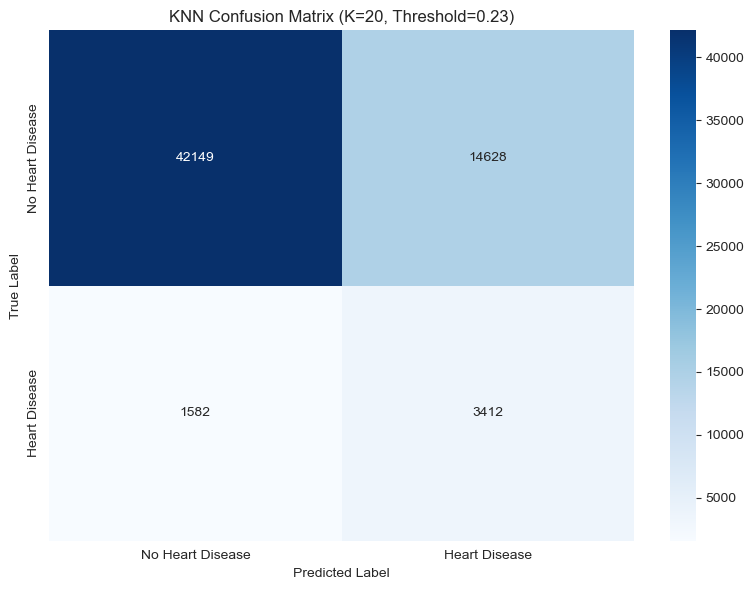

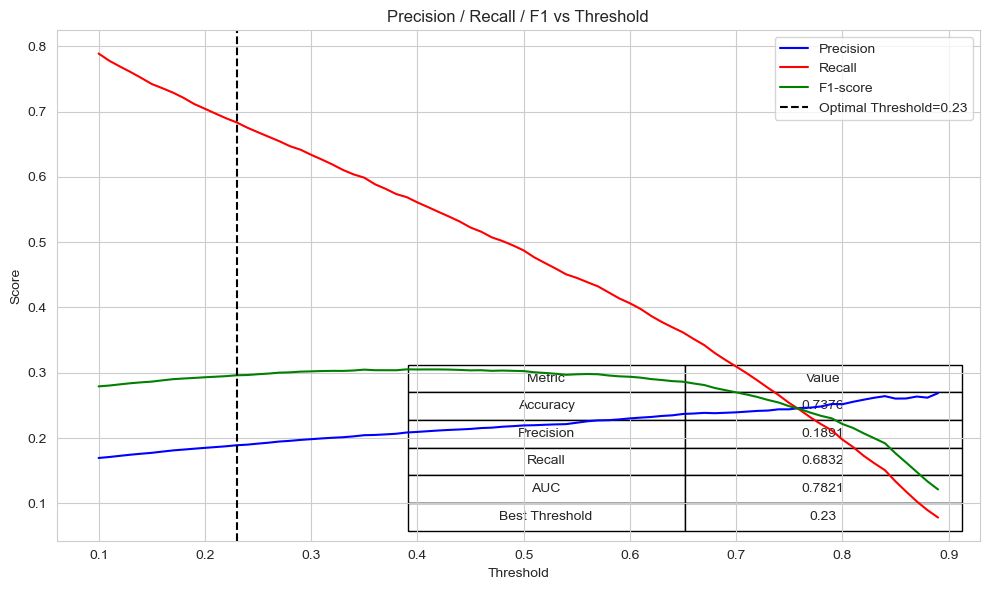


Enhanced calibrated KNN model saved successfully.


In [5]:
#KNN + SMOTE + Probability Calibration + Threshold Optimization
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# ===========================
# Settings
# ===========================
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set_style("whitegrid")

print("Starting Enhanced KNN Optimization...")

# ===========================
# Load and preprocess data
# ===========================
data = pd.read_csv('CVD_cleaned.csv').drop('Checkup', axis=1)
print(f"Data shape: {data.shape}")

def preprocess_data(df):
    """Preprocess categorical, binary, and numeric features"""
    df_processed = df.copy()
    binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
                   'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
    for col in binary_cols:
        df_processed[col] = df_processed[col].apply(lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x)).astype(int)
    categorical_cols = ['General_Health', 'Age_Category', 'Sex']
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    scaler = StandardScaler()
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])
    return df_processed, scaler

data_processed, scaler = preprocess_data(data)
X = data_processed.drop('Heart_Disease', axis=1)
y = data_processed['Heart_Disease']

# ===========================
# Train-test split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===========================
# Apply SMOTE
# ===========================
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Training set after SMOTE: {Counter(y_train_smote)}")

# ===========================
# Scan K values and train KNN
# ===========================
best_recall = 0
best_k = 3
best_model = None

for k in [3,5,7,9,11,15,20]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_smote, y_train_smote)
    y_pred = knn.predict(X_test)
    recall = recall_score(y_test, y_pred)
    if recall > best_recall:
        best_recall = recall
        best_k = k
        best_model = knn

print(f"\nBest K={best_k}, Best Recall={best_recall:.4f}")

# ===========================
# Probability calibration
# ===========================
calibrated_knn = CalibratedClassifierCV(best_model, cv=3)
calibrated_knn.fit(X_train_smote, y_train_smote)

# ===========================
# Threshold optimization
# ===========================
y_proba = calibrated_knn.predict_proba(X_test)[:,1]
thresholds = np.arange(0.1, 0.9, 0.01)
target_recall = best_recall * 0.95

best_precision = 0
best_threshold = 0.5
best_f1 = 0

precision_list = []
recall_list = []
f1_list = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    if recall >= target_recall:
        # Select the threshold with the highest F1 score
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            best_precision = precision

print(f"\nOptimal Threshold: {best_threshold:.2f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {recall_score(y_test,(y_proba>=best_threshold).astype(int)):.4f}")
print(f"F1-score: {best_f1:.4f}")

# ===========================
# Final evaluation
# ===========================
y_pred_final = (y_proba >= best_threshold).astype(int)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
accuracy_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_proba)

print("\n=== Final Model Performance ===")
print(classification_report(y_test, y_pred_final, digits=4))
print(f"AUC: {auc_final:.4f}")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")

# ===========================
# Confusion Matrix
# ===========================
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease','Heart Disease'],
            yticklabels=['No Heart Disease','Heart Disease'])
plt.title(f'Confusion Matrix\n(Enhanced KNN Optimization, K={best_k}, Threshold={best_threshold:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ===========================
# Precision/Recall/F1 vs Threshold (Line Chart)
# ===========================
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='red')
plt.plot(thresholds, f1_list, label='F1-score', color='green')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Optimal Threshold={best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold\n(Enhanced KNN Optimization)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================
# Separate Performance Table
# ===========================
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')

# Table data
cell_text = [[
    f"{accuracy_final:.4f}",
    f"{precision_final:.4f}",
    f"{recall_final:.4f}",
    f"{auc_final:.4f}",
    f"{best_threshold:.2f}"
]]
columns = ["Accuracy", "Precision", "Recall", "AUC", "Best Threshold"]

table = ax.table(cellText=cell_text,
                 colLabels=columns,
                 cellLoc='center',
                 colLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)

# Title above table
plt.title("Final Evaluation Metrics\n(Enhanced KNN Optimization)", pad=15)
plt.show()

# ===========================
# Save model and scaler
# ===========================
joblib.dump(calibrated_knn, 'enhanced_calibrated_knn.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nEnhanced calibrated KNN model saved successfully.")

Starting KNN + Feature Selection + Threshold Optimization...
Training set after SMOTE: Counter({0: 227106, 1: 227106})
Selected Features (12): ['General_Health', 'Exercise', 'Skin_Cancer', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Green_Vegetables_Consumption']

Best K=20, Best Recall=0.6840

Optimal Threshold: 0.41
Precision: 0.1953
Recall: 0.6534
F1-score: 0.3007

=== Final Model Performance ===
              precision    recall  f1-score   support

           0     0.9616    0.7631    0.8509     56777
           1     0.1953    0.6534    0.3007      4994

    accuracy                         0.7543     61771
   macro avg     0.5784    0.7083    0.5758     61771
weighted avg     0.8996    0.7543    0.8065     61771

AUC: 0.7833
Accuracy: 0.7543
Precision: 0.1953
Recall: 0.6534
F1-score: 0.3007


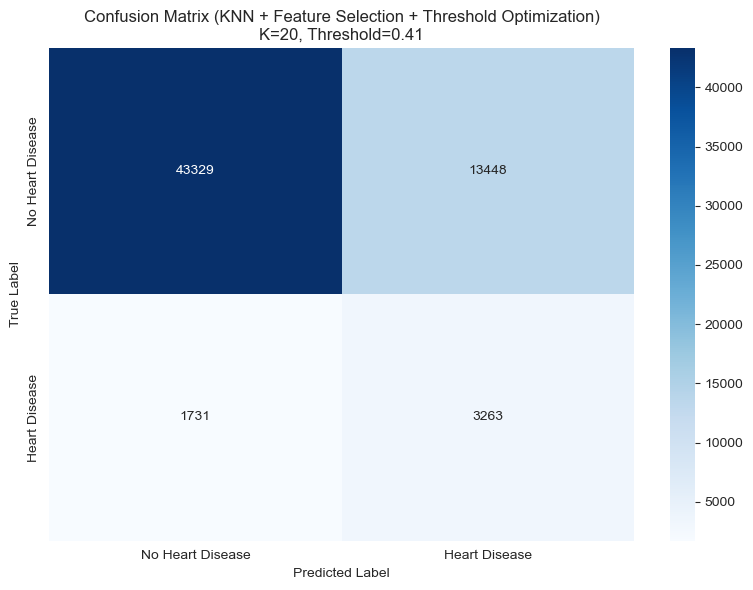

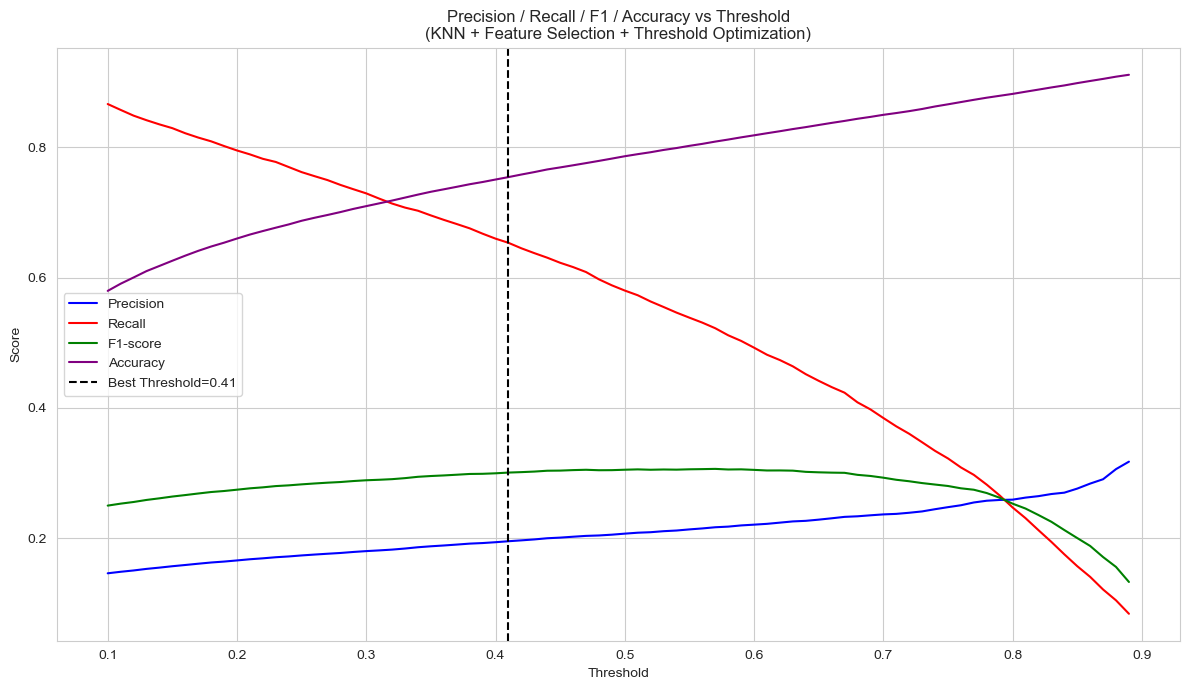

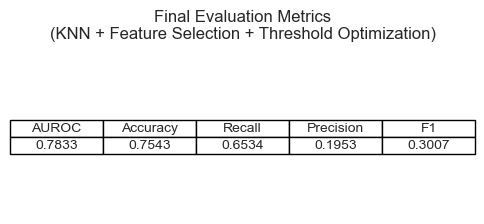


Enhanced calibrated KNN model with feature selection saved successfully.


In [7]:
# ===========================
# KNN + Feature Selection + Threshold Optimization
# ===========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# ===========================
# Settings
# ===========================
plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set_style("whitegrid")

print("Starting KNN + Feature Selection + Threshold Optimization...")

# ===========================
# Load and preprocess data
# ===========================
data = pd.read_csv('CVD_cleaned.csv').drop('Checkup', axis=1)

def preprocess_data(df):
    """Preprocess binary, categorical, and numeric variables."""
    df_processed = df.copy()
    # Binary variables
    binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
                   'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
    for col in binary_cols:
        df_processed[col] = df_processed[col].apply(lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x)).astype(int)
    # Categorical variables
    categorical_cols = ['General_Health', 'Age_Category', 'Sex']
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    # Numeric variables
    numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
    scaler = StandardScaler()
    df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])
    return df_processed, scaler

data_processed, scaler = preprocess_data(data)
X = data_processed.drop('Heart_Disease', axis=1)
y = data_processed['Heart_Disease']

# ===========================
# Train-test split & SMOTE
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Training set after SMOTE: {Counter(y_train_smote)}")

# ===========================
# Feature Selection
# ===========================
k_features = 12
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_smote, y_train_smote)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()].tolist()
print(f"Selected Features ({k_features}): {selected_features}")

# ===========================
# Scan K values to maximize Recall
# ===========================
best_recall = 0
best_k = 3
best_model = None

for k in [3, 5, 7, 9, 11, 15, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_selected, y_train_smote)
    y_pred = knn.predict(X_test_selected)
    recall = recall_score(y_test, y_pred)
    if recall > best_recall:
        best_recall = recall
        best_k = k
        best_model = knn

print(f"\nBest K={best_k}, Best Recall={best_recall:.4f}")

# ===========================
# Probability Calibration
# ===========================
calibrated_knn = CalibratedClassifierCV(best_model, cv=3)
calibrated_knn.fit(X_train_selected, y_train_smote)

# ===========================
# Threshold Optimization
# ===========================
y_proba = calibrated_knn.predict_proba(X_test_selected)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
target_recall = best_recall * 0.95

best_precision = 0
best_threshold = 0.5
best_f1 = 0

precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(acc)
    
    if recall >= target_recall and f1 > best_f1:
        best_f1 = f1
        best_threshold = t
        best_precision = precision

print(f"\nOptimal Threshold: {best_threshold:.2f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {recall_score(y_test,(y_proba>=best_threshold).astype(int)):.4f}")
print(f"F1-score: {best_f1:.4f}")

# ===========================
# Final Evaluation
# ===========================
y_pred_final = (y_proba >= best_threshold).astype(int)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_proba)

print("\n=== Final Model Performance ===")
print(classification_report(y_test, y_pred_final, digits=4))
print(f"AUC: {final_auc:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-score: {final_f1:.4f}")

# ===========================
# Confusion Matrix
# ===========================
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title(f'Confusion Matrix (KNN + Feature Selection + Threshold Optimization)\nK={best_k}, Threshold={best_threshold:.2f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ===========================
# Precision / Recall / F1 / Accuracy vs Threshold
# ===========================
plt.figure(figsize=(12, 7))
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='red')
plt.plot(thresholds, f1_list, label='F1-score', color='green')
plt.plot(thresholds, accuracy_list, label='Accuracy', color='purple')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Threshold={best_threshold:.2f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 / Accuracy vs Threshold\n(KNN + Feature Selection + Threshold Optimization)")
plt.legend(loc='center left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================
# Metrics Table Separately
# ===========================
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')

# Table content
cell_text = [[
    f"{final_auc:.4f}",
    f"{final_accuracy:.4f}",
    f"{final_recall:.4f}",
    f"{final_precision:.4f}",
    f"{final_f1:.4f}"
]]
columns = ["AUROC", "Accuracy", "Recall", "Precision", "F1"]

# Create table
table = ax.table(
    cellText=cell_text,
    colLabels=columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)

# Add a title above the table
plt.title("Final Evaluation Metrics\n(KNN + Feature Selection + Threshold Optimization)", pad=15)
plt.show()

# ===========================
# Save Model & Scaler
# ===========================
joblib.dump(calibrated_knn, 'enhanced_knn_fs_calibrated.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nEnhanced calibrated KNN model with feature selection saved successfully.")

